- Two Sample T-Tests (for an association between a quantitative variable and a binary categorical variable)
- ANOVA and Tukey Tests (for an association between a quantitative variable and a non-binary categorical variable)
- Chi-Square Tests (for an association between two categorical variables)

Two-Sample T-Test
Suppose that a company is considering a new color-scheme for their website. They think that visitors will spend more time on the site if it is brightly colored. To test this theory, the company shows the old and new versions of the website to 50 site visitors, each — and finds that, on average, visitors spent 2 minutes longer on the new version compared to the old. Will this be true of future visitors as well? Or could this have happened by random chance among the 100 people in this sample?

One way of testing this is with a 2-sample t-test. The null hypothesis for this test is that average length of a visit does not differ based on the color of the website. In other words, if we could observe all site visitors in two alternate universes (one where they see each version of the site), the average visiting times in these universes would be equal.

We can use SciPy’s ttest_ind() function to perform a 2-sample t-test. It takes the values for each group as inputs and returns the t-statistic and a p-value.

`from scipy.stats import ttest_ind`

`tstat, pval = ttest_ind(times_version1, times_version2)`

The company randomly sampled 100 site visitors. They showed the old version of their website to half of their sample and the new version to the other half. The amount of time (in minutes) that each visitor spent on the website was recorded.



In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
data = pd.read_csv('../Datasets/version_time.csv')
data.head()

,time_minutes,version
0,11.92,new
1,12.90,old
2,13.76,old
3,15.68,old
4,16.28,old


In [3]:
new = data[data['version'] == 'new']['time_minutes']
old = data[data['version'] == 'old']['time_minutes']

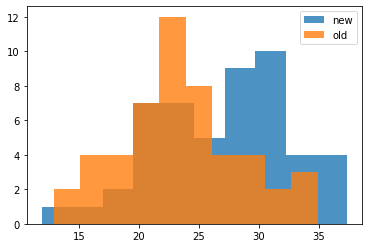

In [8]:
#Plot overlapping histograms
plt.hist(new, alpha = 0.8, label = 'new')
plt.hist(old, alpha = 0.8, label = 'old')
plt.legend()
plt.show()

There is a fair amount of overlap, but it does seem like visitors to the new website are spending slightly more time on the site (the orange distribution is shifted slightly to the right of the blue distribution).

In [11]:
print(np.mean(new))
print(np.mean(old))

26.884
23.53


In [12]:
#run the t-test here:
tstat, pval = ttest_ind(old, new)
print(pval)

0.0020408264429904


Since the p-value is less than 0.05, we can conclude there is a significant difference.

#### Multiple Tests
In the previous exercise, we used a two-sample t-test to investigate an association between a quantitative variable (time spent on a website) and a binary categorical variable (an old color scheme or a new color scheme).

In some circumstances, we might instead care about an association between a quantitative variable and a non-binary categorical variable (non-binary means more than two categories).

For example, suppose that we own a chain of stores that sell ants, called VeryAnts. There are three different locations: A, B, and C. We want to know whether customers are spending a significantly different amount per order at any of the locations.

There are three different comparisons we could make: A vs. B, B vs. C, and A vs. C. One way to answer our question is to simply run three separate 2-sample t-tests.

In [15]:
veryants = pd.read_csv('../Datasets/veryants.csv')
veryants.head(3)

,Sale,Store
0,73.57,A
1,38.37,A
2,49.36,A


In [16]:
veryants.tail(3)

,Sale,Store
447,46.77,C
448,70.39,C
449,42.06,C


In [ ]:
a = veryants.